In [1]:
%matplotlib inline
import os

import cftime

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import cmocean

import cartopy
import cartopy.crs as ccrs

import esmlab

import intake
import intake_esm
import ncar_jobqueue
from dask.distributed import Client
from pint import UnitRegistry

units = UnitRegistry()
units.define('micromoles_per_kilogram = umol / kg') # used in WOA datasets

%load_ext watermark
%watermark -a "Mike Levy" -d -iv -m -g -h

cmocean       2.0
cartopy       0.17.0
intake        0.5.3
numpy         1.17.3
ncar_jobqueue 2019.10.16.1
esmlab        2019.4.27.post55
cftime        1.0.3.4
intake_esm    2019.10.15.post40
xarray        0.14.0
matplotlib    3.1.2
Mike Levy 2019-12-18 

compiler   : GCC 7.3.0
system     : Linux
release    : 3.10.0-693.21.1.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 72
interpreter: 64bit
host name  : casper03
Git hash   : abfa5509ab9a00bba671ef2f89af129286081506


In [2]:
cluster = ncar_jobqueue.NCARCluster(project='P93300606')
client = Client(cluster)
client

Client Scheduler: tcp://128.117.181.209:41945 Dashboard: https://jupyterhub.ucar.edu/dav/user/mlevy/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
cluster.scale(8)

In [4]:
def _read_var(dq, time_slice, variable):
    # Define datasets
    dataset = dq['ocn.historical.pop.h']

    keep_vars = ['REGION_MASK', 'z_t', 'dz', 'TAREA', 'TLONG', 'TLAT', 'time', 'time_bound', 'member_id', 'ctrl_member_id'] + [variable]
    dataset = dataset.drop([v for v in dataset.variables if v not in keep_vars]).sel(time=time_slice).mean(dim=['member_id', 'time'])

    return(dataset)

In [5]:
def read_var_WOA(variable):
    woa_root=os.path.join(os.path.sep, 'glade', 'p', 'cgd', 'oce', 'projects',
                          'cesm2-marbl', 'woa2018-data', 'POP_gx1v7', 'annual')
    varmap = {'NO3' : 'n', 'PO4' : 'p', 'SiO3' : 'i'}
    filename=f'woa18_all_{varmap[variable]}00_gx1v7.nc'
    ds=xr.open_dataset(os.path.join(woa_root, filename), decode_times=False).isel(time=0)
    return(ds)

In [6]:
nutrients = ['NO3', 'PO4', 'SiO3']

In [7]:
%%time

catalog = intake.open_esm_datastore('/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/campaign-cesm2-cmip6-timeseries.json')

da_surf = dict()
ds = dict()
da_surf_obs = dict()
ds_obs = dict()

for variable in nutrients:
    # Read CESM and WOA data
    dq = catalog.search(experiment='historical', component='ocn', variable=variable).to_dataset_dict(cdf_kwargs={'chunks':{'time': 48}})
    ds[variable] = _read_var(dq, slice("1990-01-15", "2015-01-15"), variable) # 1990 - 2014, inclusive
    ds_obs[variable] = read_var_WOA(variable)

    da_tmp = ds[variable][variable].compute()
    da_surf[variable] = (da_tmp.isel(z_t=0).data * units[ds[variable][variable].attrs['units']])
    da_tmp = ds_obs[variable][variable]
    da_surf_obs[variable]=da_tmp.isel(z_t=0).data * units[da_tmp.attrs['units']] * (1026*units['kg/m^3'])

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'

--> There will be 1 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'

--> There will be 1 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'

--> There will be 1 group(s)
CPU times: user 49.8 s, sys: 6.33 s, total: 56.2 s
Wall time: 6min 5s


In [8]:
def plot_surface_vals(variable, ds, da, obs):
    TLONG = ds[variable].TLONG
    TLAT = ds[variable].TLAT
    computed = da[variable]
    observed = obs[variable]   
    bias=computed-observed # convert to /vol rather than /mass

    # Determine contours
    min_lev = 0
    if variable == 'NO3':
        max_lev = 42
    if variable == 'PO4':
        max_lev = 3.2
    if variable == 'SiO3':
        max_lev = 180
    levels = MaxNLocator(nbins=15).tick_values(min_lev, max_lev)
    cmap = plt.get_cmap('rainbow')
    norm = BoundaryNorm(levels, ncolors=cmap.N)

    fig = plt.figure(figsize=(8, 14))
    ax = plt.subplot(3, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))

    pc = ax.pcolormesh(TLONG,
                       TLAT,
                       computed.to('mmol/m^3').magnitude,
                       cmap=cmap,
                       transform=ccrs.PlateCarree(),
                       norm=norm)

    # ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
    #                                                    edgecolor='face',
    #                                                    facecolor='lightgray'))
    ax.set_global() 
    ax.coastlines(linewidth=0.5)
    cb = plt.colorbar(pc, shrink=0.6)
    ax.set_title(f'{variable} from POP run');
    cb.set_label('$\mathrm{mmol/m^3}$')

    ax = plt.subplot(3, 1, 2, projection=ccrs.Robinson(central_longitude=305.0))

    pc = ax.pcolormesh(TLONG,
                       TLAT,
                       observed.to('mmol/m^3').magnitude,
                       cmap=cmap,
                       transform=ccrs.PlateCarree(),
                       norm=norm)

    # ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
    #                                                    edgecolor='face',
    #                                                    facecolor='lightgray'))
    ax.set_global() 
    ax.coastlines(linewidth=0.5)
    cb = plt.colorbar(pc, shrink=0.6)
    ax.set_title(f'{variable} from WOA');
    cb.set_label('$\mathrm{mmol/m^3}$')
    
    ax = plt.subplot(3, 1, 3, projection=ccrs.Robinson(central_longitude=305.0))

    pc = ax.pcolormesh(TLONG,
                       TLAT,
                       bias.to('mmol/m^3').magnitude,
                       cmap=plt.get_cmap('bwr'),
                       transform=ccrs.PlateCarree())

    # ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
    #                                                    edgecolor='face',
    #                                                    facecolor='lightgray'))
    ax.set_global() 
    ax.coastlines(linewidth=0.5)
    cb = plt.colorbar(pc, shrink=0.6)
    ax.set_title(f'Bias in {variable}');
    cb.set_label('$\mathrm{mmol/m^3}$')


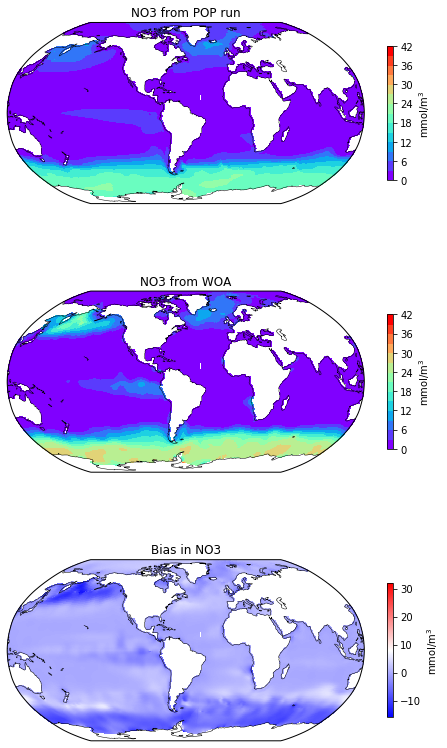

In [9]:
plot_surface_vals('NO3', ds, da_surf, da_surf_obs)

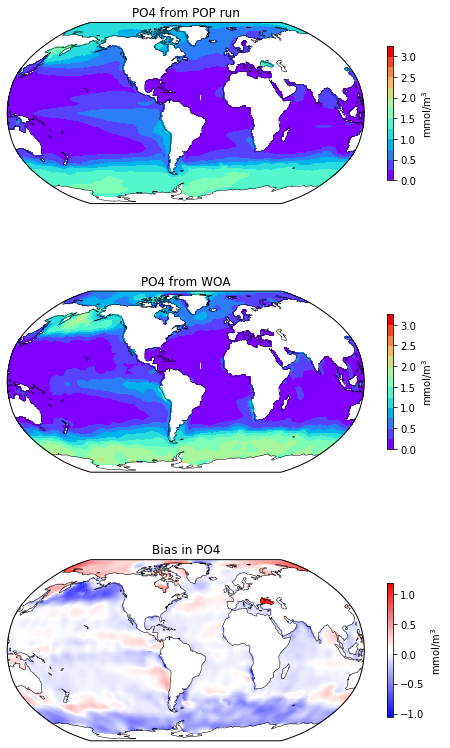

In [10]:
plot_surface_vals('PO4', ds, da_surf, da_surf_obs)

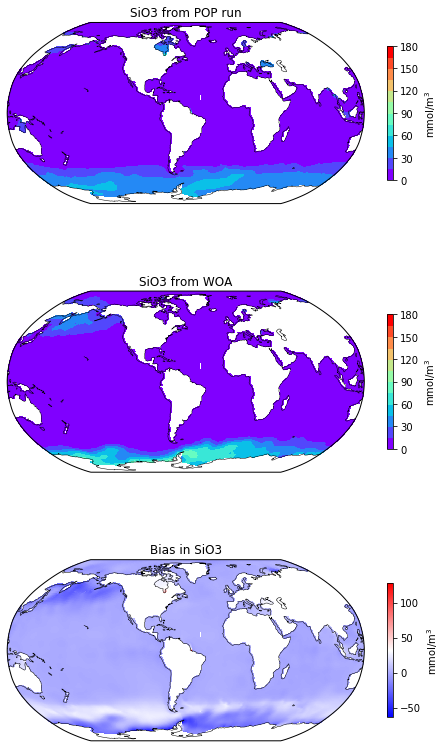

In [11]:
plot_surface_vals('SiO3', ds, da_surf, da_surf_obs)

## Compute global profile

Here we use `esmlab` to average over lat / lon, but leave depth

In [12]:
%%time

glb_avg = dict()
glb_avg_obs = dict()

for variable in nutrients:
    print(f'Computing weighted mean of {variable} for CESM output...')
    da_tmp = esmlab.weighted_mean(ds[variable][variable], weights=ds[variable].TAREA, dim=['nlat', 'nlon']).compute()
    glb_avg[variable] = (da_tmp.data * units[ds[variable][variable].attrs['units']])

    print(f'Computing weighted mean of {variable} for WOA data...')
    da_tmp = esmlab.weighted_mean(ds_obs[variable][variable], weights=ds_obs[variable].TAREA, dim=['nlat', 'nlon']).compute()
    glb_avg_obs[variable] = ((da_tmp.data * units[ds_obs[variable][variable].attrs['units']]) * (1026*units['kg/m^3'])).to('mmol/m^3')


Computing weighted mean of NO3 for CESM output...
Computing weighted mean of NO3 for WOA data...
Computing weighted mean of PO4 for CESM output...
Computing weighted mean of PO4 for WOA data...
Computing weighted mean of SiO3 for CESM output...
Computing weighted mean of SiO3 for WOA data...
CPU times: user 44.5 s, sys: 5.3 s, total: 49.8 s
Wall time: 5min 31s


In [13]:
def plot_global_profile(variables, ds, da, obs):
    plt_cnt = len(variables)
    z = ds[variables[0]].z_t.data * units[ds[variables[0]]['z_t'].attrs['units']]

    fig = plt.figure(figsize=(4*plt_cnt, 4))
    for n, variable in enumerate(variables):
        computed = da[variable]
        observed = obs[variable]   

        ax = fig.add_subplot(1, plt_cnt, n+1)

        ax.plot(computed.magnitude, (z.to('m')).magnitude, 'b-', label='CESM2', linewidth=2)
        ax.plot(observed.magnitude, (z.to('m')).magnitude, 'r:', label='WOA2018', linewidth=2)

        ax.set_title(f'Global Profile of {variable}')
        ax.set(xlabel='concentration (mmol m$^{-3}$)')
        if n == 0:
            ax.set(ylabel='depth (m)')
        else:
            ax.set_yticklabels('')
        plt.gca().invert_yaxis()
        ax.legend()

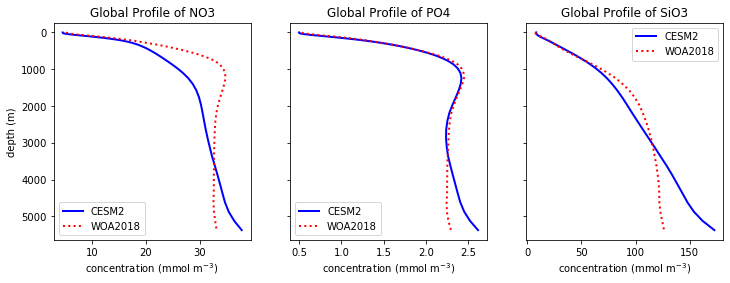

In [14]:
plot_global_profile(nutrients, ds, glb_avg, glb_avg_obs)